In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import spacy
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import Word2Vec
import numpy as np
import pandas as pd

In [92]:
# Download necessary resources
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
df = pd.read_csv('/content/drive/MyDrive/YoutubeCommentsDataSet.csv')
df.head()

Comment Sentiment
0  lets not forget that apple pay in 2014 require...   neutral
1  here in nz 50 of retailers don’t even have con...  negative
2  i will forever acknowledge this channel with t...  positive
3  whenever i go to a place that doesn’t take app...  negative
4  apple pay is so convenient secure and easy to ...  positive

In [10]:
df.shape

(18408, 2)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18408 entries, 0 to 18407
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    18364 non-null  object
 1   Sentiment  18408 non-null  object
dtypes: object(2)
memory usage: 287.8+ KB


In [12]:
df.describe()

Comment Sentiment
count                                               18364     18408
unique                                              17871         3
top     one of the best thing about dude is that he ne...  positive
freq                                                   10     11432

In [13]:
#Function to remove punctuation

def remove_punctuation(words):
    words = words.lower()
    return ''.join([x for x in words if x not in string.punctuation])

In [15]:
#Removing stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(words):
  return ' '.join([x for x in words.split() if x not in stop_words])

In [63]:
#Tokenization
tokenized_comments = df['Comment'].astype(str).apply(lambda x: word_tokenize(x))
filtered_tokens = [word for comment in tokenized_comments for word in comment if word.isalnum() and word.lower() not in stop_words]


In [21]:
#Remove noise
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
df['Comment'] = df['Comment'].replace(to_replace = pattern_url, value = subs_url, regex = True)
df['Comment'] = df['Comment'].str.lower()

In [22]:
def bag_of_words_count(words, word_dict={}):
    """ this function takes in a list of words and returns a dictionary
        with each word as a key, and the value represents the number of
        times that word appeared"""
    for word in words:
        if word in word_dict.keys():
            word_dict[word] += 1
        else:
            word_dict[word] = 1
    return word_dict

In [25]:
#Create a list of all the Comment personality types that are present in the original dataset
type_labels = list(df['Comment'].unique())

In [29]:
personality = {}
for sentiment in df['Sentiment'].unique():  # Iterate through unique sentiments
    grouped_data = df.groupby('Sentiment')
    personality[sentiment] = {}  # Use sentiment as key for personality dict
    for row in grouped_data.get_group(sentiment)['Comment'].str.split():
        # Check if row is not nan and is iterable before processing
        if row is not np.nan and hasattr(row, '__iter__'):
            personality[sentiment] = bag_of_words_count(row, personality[sentiment])

In [31]:
all_words = set()
for sentiment in personality:  # Iterate through sentiments, which are the keys of personality
    for word in personality[sentiment]:  # Access words associated with each sentiment
        all_words.add(word)

In [33]:
personality['all'] = {}
for sentiment in personality.keys():  # Iterate through sentiments in 'personality'
    for word in all_words:
        # Check if the word is present in the sentiment's dictionary
        if word in personality[sentiment]:
            # Update the count in the 'all' dictionary
            personality['all'][word] = personality['all'].get(word, 0) + personality[sentiment][word]

In [34]:
total_words = sum([v for v in personality['all'].values()])
total_words

1209550

In [36]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'word frequency')

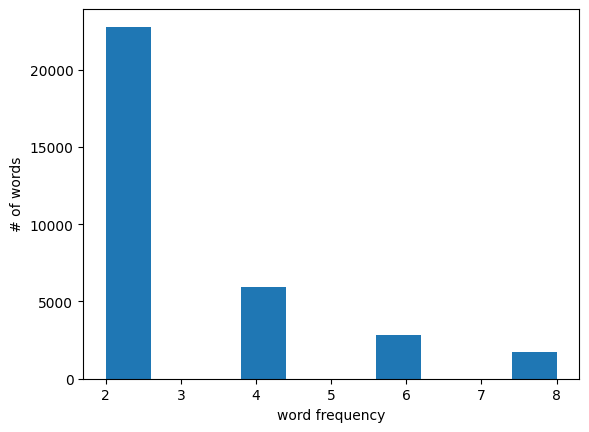

In [37]:
_ = plt.hist([v for v in personality['all'].values() if v < 10],bins=10)
plt.ylabel("# of words")
plt.xlabel("word frequency")

In [38]:
len([v for v in personality['all'].values() if v == 1])

0

In [39]:
rare_words = [k for k, v in personality['all'].items() if v==1]
print(rare_words[:100])

[]


In [40]:
# How many words appear more than 10 times?
# How many words of the total does that account for?
print(len([v for v in personality['all'].values() if v >= 10]))
occurs_more_than_10_times = sum([v for v in personality['all'].values() if v >= 10])
print(occurs_more_than_10_times)

8175
1109626


In [41]:
occurs_more_than_10_times/total_words

0.9173874581455913

In [42]:
max_count = 10
remaining_word_index = [k for k, v in personality['all'].items() if v > max_count]

In [43]:
from nltk.util import ngrams

In [44]:
def word_grams(words, min_n=1, max_n=4):
    s = []
    for n in range(min_n, max_n):
        for ngram in ngrams(words, n):
            s.append(' '.join(str(i) for i in ngram))
    return s

In [52]:
# Add tokenized comments as a new column to the DataFrame
df['tokenized_comments'] = tokenized_comments
# Use an index within the bounds of the DataFrame
index_to_use = 5  # Choose an index between 0 and 18407
[x for x in ngrams(df['tokenized_comments'].iloc[index_to_use], 2)]

[('we', '’'),
 ('’', 've'),
 ('ve', 'been'),
 ('been', 'hounding'),
 ('hounding', 'my'),
 ('my', 'bank'),
 ('bank', 'to'),
 ('to', 'adopt'),
 ('adopt', 'apple'),
 ('apple', 'pay'),
 ('pay', 'i'),
 ('i', 'understand'),
 ('understand', 'why'),
 ('why', 'they'),
 ('they', 'don'),
 ('don', '’'),
 ('’', 't'),
 ('t', 'want'),
 ('want', 'to'),
 ('to', 'do'),
 ('do', 'it'),
 ('it', 'with'),
 ('with', 'the'),
 ('the', 'extra'),
 ('extra', 'fees'),
 ('fees', 'but'),
 ('but', 'its'),
 ('its', 'just'),
 ('just', 'so'),
 ('so', 'easy'),
 ('easy', 'and'),
 ('and', 'quick'),
 ('quick', 'at'),
 ('at', 'the'),
 ('the', 'checkout')]

In [57]:
from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer

In [76]:
# Lemmatization
lemmatizer = WordNetLemmatizer()
lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

In [72]:
# Word Frequency
word_freq = Counter(lemmatized_tokens)

In [79]:
# Convert list of tokens into a single string
lemmatized_text = " ".join(lemmatized_tokens)
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform([lemmatized_text])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [80]:

# Topic Modeling using Latent Dirichlet Allocation (LDA)
lda = LatentDirichletAllocation(n_components=2, random_state=42)
lda_matrix = lda.fit_transform(tfidf_matrix)
topics = {f"Topic {i}": lda.components_[i] for i in range(len(lda.components_))}

In [87]:
# Apply sentence tokenization to each comment in the DataFrame
df['sentences'] = df['Comment'].astype(str).apply(sent_tokenize)
# Flatten list of sentences from all comments
sentences = [sent for sublist in df['Sentences'] for sent in sublist]
# Tokenize each sentence
sentences_tokens = [word_tokenize(sent.lower()) for sent in sentences]

In [88]:
# Word Embeddings using Word2Vec
sentences_tokens = [word_tokenize(sent.lower()) for sent in sentences]
word2vec_model = Word2Vec(sentences_tokens, vector_size=50, window=5, min_count=1, workers=4)
word_vectors = {word: word2vec_model.wv[word] for word in word2vec_model.wv.index_to_key}

In [89]:
print("Sentences:", sentences)
print("Tokens:", lemmatized_tokens)
print("Word Frequencies:", word_freq)
print("TF-IDF Features:", dict(zip(tfidf_feature_names, tfidf_matrix.toarray()[0])))
print("LDA Topics:", topics)
print("Word Embeddings:", {word: vec.tolist() for word, vec in list(word_vectors.items())[:5]})

Sentences: ['lets not forget that apple pay in 2014 required a brand new iphone in order to use it a significant portion of apples user base wasnt able to use it even if they wanted to as each successive iphone incorporated the technology and older iphones were replaced the number of people who could use the technology increased', 'here in nz 50 of retailers don’t even have contactless credit card machines like paywave which support apple pay they don’t like the high fees that come with these', 'i will forever acknowledge this channel with the help of your lessons and ideas explanations now its quite helpful while youll just sit at your comfort and monitor your account growth', 'whenever i go to a place that doesn’t take apple pay doesn’t happen too often it’s such a drag between ‘contactless covid’ habits and my getting the apple card i’ve gotten so used to apple pay that i get seriously annoyed when a store doesn’t take it it feels like a shock it’s crazy how quickly it took over my 